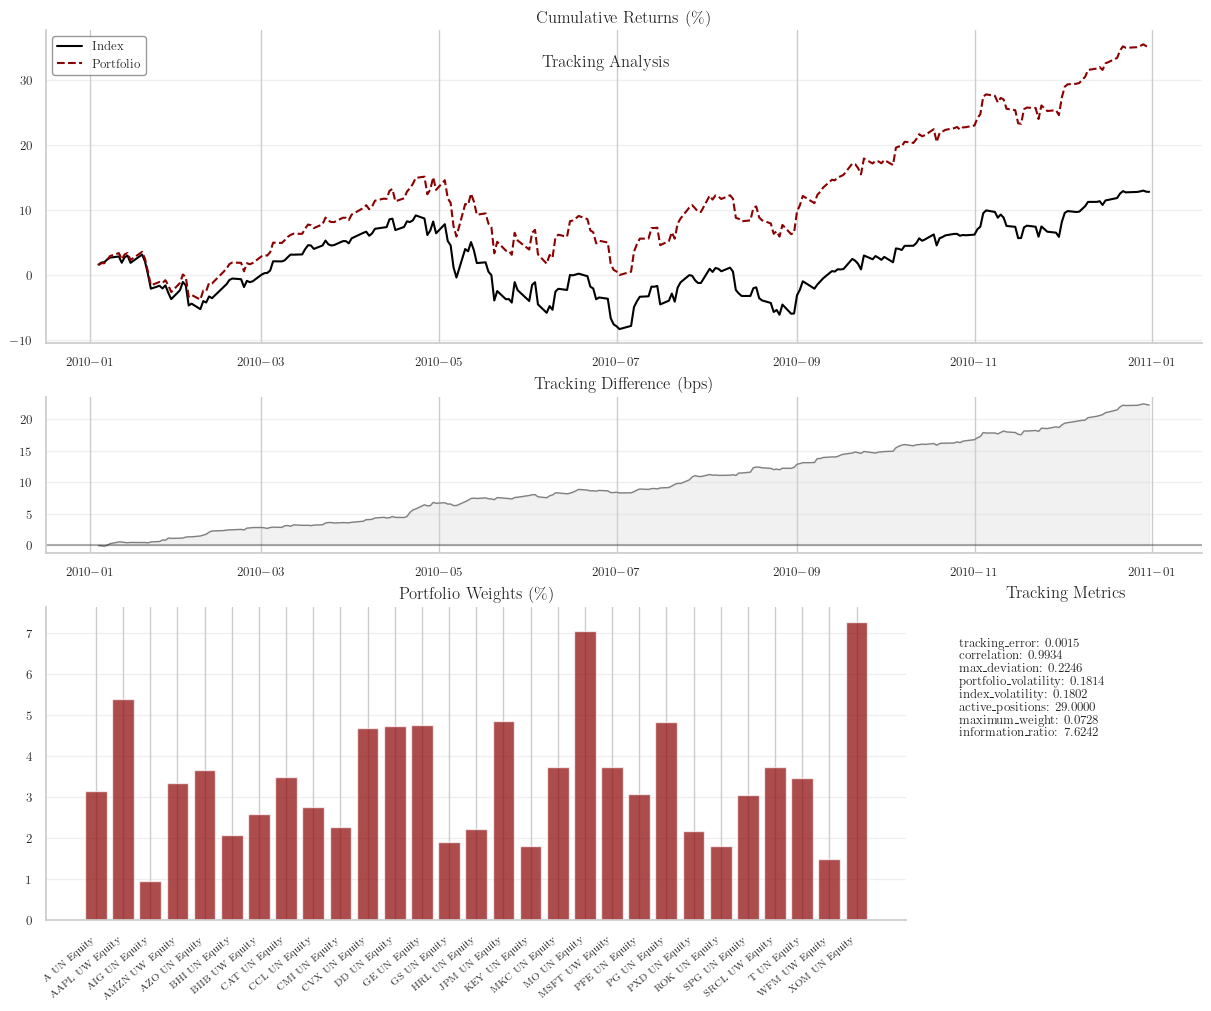

In [1]:
import polars as pl
from replicate.data.loading import DataLoader
from replicate.data.paths import DataPaths
from replicate.data.align import align

from replicate.optimizers.mm import MMOptimizer
from replicate.evaluation.metrics import TrackingMetrics
from replicate.evaluation.visualizer import TrackingVisualizer

optimizer = MMOptimizer(measure='dr')

# Load data
loader = DataLoader(date_col='Date')
constituents, _ = loader.load_data("SP500_CONSTITUENTS")
target, _ = loader.load_data("SP500_INDEX")
constituents, target = align(constituents, target, on='Date')

X = constituents.drop('Date').collect().to_numpy()
r = target.drop('Date').collect().to_numpy().flatten() # we expect 1d array
dates = target.select('Date').collect().to_numpy().flatten()
asset_names = [c for c in constituents.collect_schema().names() if c != 'Date']

# Optimize weights
result_dict = optimizer.optimize(X, r, lambda_=1e-7, u=0.5, hub=0.5)
weights = result_dict['weights']

# Calculate metrics
metrics = TrackingMetrics.calculate_metrics(
    X @ weights,
    r,
    weights
)

# Visualize results
TrackingVisualizer.plot_tracking_analysis(
    dates,
    X @ weights,
    r,
    weights,
    asset_names,
    metrics=metrics
);

In [3]:
from replicate.optimizers.kkt import project_weights_kkt, demonstrate_kkt_projection

demonstrate_kkt_projection()

Case 1 (no upper bound hits):
Input c: [0.1 0.2 0.3 0.4]
Weights: [0.325 0.275 0.225 0.175]
Sum of weights: 1.0

Case 2 (with upper bound hits):
Input c: [-0.5 -0.4  0.1  0.2]
Weights: [0.4        0.38333333 0.13333333 0.08333333]
Sum of weights: 1.0
Max weight: 0.4
Case 3 (too small u):
Input c: [0.1 0.2 0.3]
Weights: [0.1 0.1 0.1]
Sum of weights: 0.30000000000000004
Case 4 (large values):
Input c: [  100000.  1000000. 10000000.]
Weights: [0.5 0.5 0. ]
Sum of weights: 1.0


In [ ]:
from replicate.optimizers.kkt import project_weights_kkt, demonstrate_kkt_projection

demonstrate_kkt_projection()

Case 1 (no upper bound hits):
Input c: [0.1 0.2 0.3 0.4]
Weights: [0.325 0.275 0.225 0.175]
Sum of weights: 1.0

Case 2 (with upper bound hits):
Input c: [-0.5 -0.4  0.1  0.2]
Weights: [0.4        0.38333333 0.13333333 0.08333333]
Sum of weights: 1.0
Max weight: 0.4
Case 3 (too small u):
Input c: [0.1 0.2 0.3]
Weights: [0.1 0.1 0.1]
Sum of weights: 0.30000000000000004
Case 4 (large values):
Input c: [  100000.  1000000. 10000000.]
Weights: [0.5 0.5 0. ]
Sum of weights: 1.0


In [3]:
import numpy as np
def debug_dr_comparison():
    """Compare DR update with fixed values."""
    # Simple fixed values
    X = np.array([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ])
    r = np.array([0.1, 0.1, 0.1])
    w = np.array([1/3, 1/3, 1/3])
    lambda_ = 1e-7
    p = 0.1
    u = 0.5
    c1 = np.log(1 + u/p)
    
    print("Python intermediate values:")
    print(f"X:\n{X}")
    print(f"r: {r}")
    print(f"w: {w}")
    
    m = X.shape[0]
    
    # Compute matrices
    A = (1/m) * X.T @ X
    print(f"\nA:\n{A}")
    
    Lmax_A = np.linalg.eigvalsh(A)[-1]
    print(f"\nLmax_A: {Lmax_A}")
    
    B = (2/Lmax_A) * (A - Lmax_A * np.eye(X.shape[1]))
    print(f"\nB:\n{B}")
    
    b = (-2/m) * X.T @ r
    print(f"\nb: {b}")
    
    h = np.minimum(r - X @ w, 0)
    print(f"\nh: {h}")
    
    d = lambda_ / ((p + np.abs(w)) * c1)
    print(f"\nd: {d}")
    
    c = B @ w + (1/Lmax_A) * (b + d + 2/m * X.T @ h)
    print(f"\nc: {c}")

debug_dr_comparison()

Python intermediate values:
X:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
r: [0.1 0.1 0.1]
w: [0.33333333 0.33333333 0.33333333]

A:
[[0.33333333 0.         0.        ]
 [0.         0.33333333 0.        ]
 [0.         0.         0.33333333]]

Lmax_A: 0.3333333333333333

B:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

b: [-0.06666667 -0.06666667 -0.06666667]

h: [-0.23333333 -0.23333333 -0.23333333]

d: [1.2879476e-07 1.2879476e-07 1.2879476e-07]

c: [-0.66666628 -0.66666628 -0.66666628]
